# Generating a Micromodel Using an XCT Core (100 x 100)
---

This is an example notebook for creating a micromodel from start to finish. Optionally, ```svglib``` and ```reportlab``` can be used to convert the generated SVG file into a rasterized image, such as a PNG.

**Developed by**:
Aramy Truong, Postbachelors Research Associate - Terrestrial and Atmospheric Processes - Pacific Northwest National Laboratory, Richland, WA, USA.

**Mentors**:
Arunima Bhattacharjee and
Maruti K. Mudunuru

In [ ]:
# Installing svglib and reportlab for exporting to a rasterized image format (does not come included in Pore2Chip requirements)
%pip install svglib
%pip install reportlab==3.6.13

In [1]:
# Importing necessary libraries
from pore2chip import metrics, filter_im, coordination, generate, export
import cv2 as cv
import os
import copy
import numpy as np
from matplotlib import pyplot as plt

# Imported for basic visualization
import porespy as ps
import openpnm as op

from svglib.svglib import svg2rlg
from reportlab.graphics import renderPM

path = os.getcwd()

%load_ext autoreload
%autoreload 2

## Inputing Images and Filtering
---
Here is an example for importing XCT images. Pore2Chip has functions for reading an array of images or reading images in a file directory for filtering. Both methods are below. NOTE: PoreSpy treats white pixels as pore space. Use the "invert" parameter to invert the filtered images,

## Method 1:
Read images externally and filter images using ```filter_im.filter```. If you already have images loaded in memory, this function will filter it using Otsu's filtering.

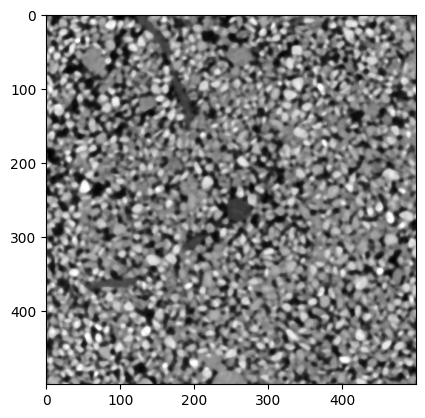

In [ ]:
image_path = r'bean_bucket_100/'
image_list_3D = np.zeros((100, 500, 500), dtype = np.uint8)

stride = 0
for file in os.listdir(image_path):
    image = cv.imread(image_path + file, cv.IMREAD_GRAYSCALE)
    image_list_3D[stride,:,:] = copy.deepcopy(image)
    stride += 1

fig, ax = plt.subplots()
ax.imshow(image_list_3D[0,:,:], cmap='gray')

Here is where we filter the images from image data loaded in memory.

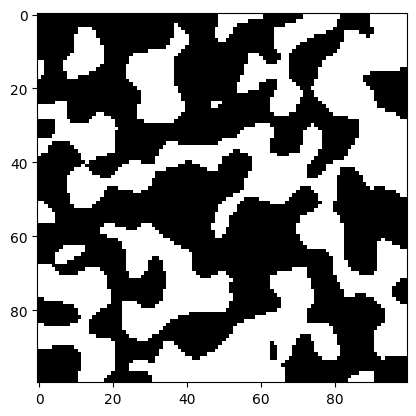

In [7]:
# Filter image and crop image down to 100 x 100, with a depth of 100
filtered_images = filter_im.filter_list(image_list_3D, [0, 100], [0, 100], 100, invert=True)
fig, ax = plt.subplots()
ax.imshow(filtered_images[0,:,:], cmap='gray')

## Method 2:
Input image path and filter using ```filter_im.read_and_filter_list```. This will load and filter the image files in one go. All parameters after the image_path variable are option. If no depth is given, All of the images in the directory will be loaded.

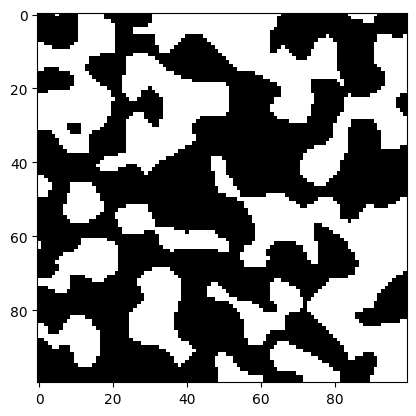

In [2]:
image_path = r'bean_bucket_100/'
filtered_images = filter_im.read_and_filter_list(image_path, [0, 100], [0, 100], 100, invert=True)

fig, ax = plt.subplots()
ax.imshow(filtered_images[1,:,:], cmap='gray')

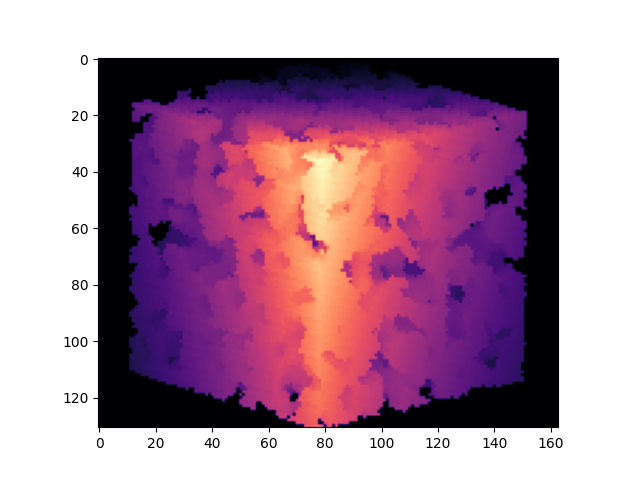

In [5]:
im_3d = ps.visualization.show_3D(filtered_images)
fig, ax = plt.subplots()
ax.imshow(im_3d, cmap=plt.cm.magma)

## Getting Metrics
---
To generate a micromodel, a list of pore diameters, throat diameters, and coordination numbers are required. To extract this information, use the ```metrics``` module.

In [3]:
%%capture
pore_diameters, throat_diameters = metrics.extract_diameters(filtered_images)

Text(0, 0.5, 'Probability Density')

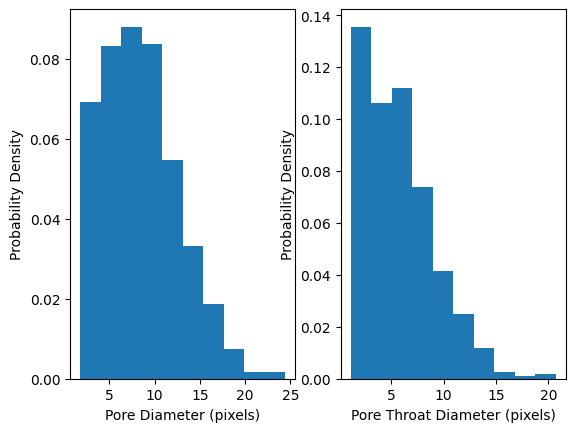

In [4]:
# Plot Probability Densities
fig, ax = plt.subplots(1, 2)

ret = ax[0].hist(pore_diameters, density = True)
ret2 = ax[1].hist(throat_diameters, density = True)
ax[0].set_xlabel("Pore Diameter (pixels)")
ax[0].set_ylabel("Probability Density")
ax[1].set_xlabel("Pore Throat Diameter (pixels)")
ax[1].set_ylabel("Probability Density")

In [5]:
%%capture
coordination_numbers = coordination.coordination_nums_3D(filtered_images)

Text(0, 0.5, 'Probability Density')

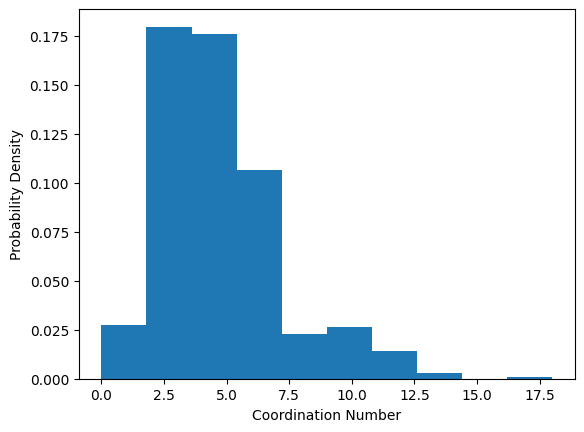

In [6]:
# Plot Probability Densities
fig, ax = plt.subplots()

ret = ax.hist(coordination_numbers, density = True)
ax.set_xlabel("Coordination Number")
ax.set_ylabel("Probability Density")

## Generating the Network
---
In the following examples, we will generate a network that is 10 x 10, and 30 x 30 in size. We can acheive this using the same data extracted from the XCT images.

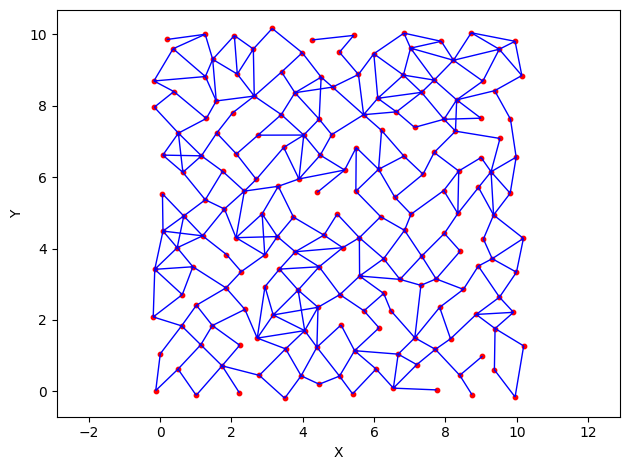

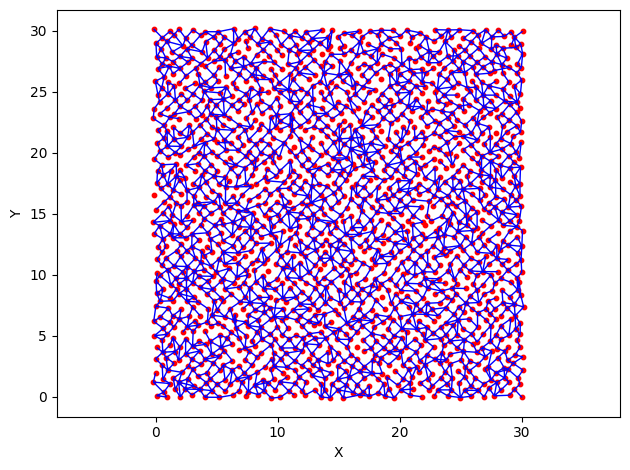

In [25]:
# Here, we generate 2 pore networks. One is 10 x 10, while the other is 30 x 30
network1 = generate.generate_network(10, 10, pore_diameters, throat_diameters, coordination_numbers, center_channel=3)
network2 = generate.generate_network(30, 30, pore_diameters, throat_diameters, coordination_numbers, center_channel=10)

#fig, ax = plt.subplots(2, 1)

h1 = op.visualization.plot_connections(network1)
h2 = op.visualization.plot_connections(network2)
op.visualization.plot_coordinates(network1, ax=h1)
op.visualization.plot_coordinates(network2, ax=h2)

In [ ]:
network = p2c.generate.generate_network(
                                        6, 18, 
                                        pore_diameters, 
                                        throat_diameters, 
                                        coordination_numbers, 
                                        center_channel=3
                                       )

h = op.visualization.plot_connections(network)
op.visualization.plot_coordinates(network, ax=h)

## Comparing Pore Size Distributions, Throat Size Distributions, and Coordination Number Distributions between XCT Data and 2 Micromodels
---
We can compare the distributions extracted from XCT data to distributions that are ultimately selected for generating the micromodels here using histograms. These distributions generally follow a power-law or log-normal distribution.

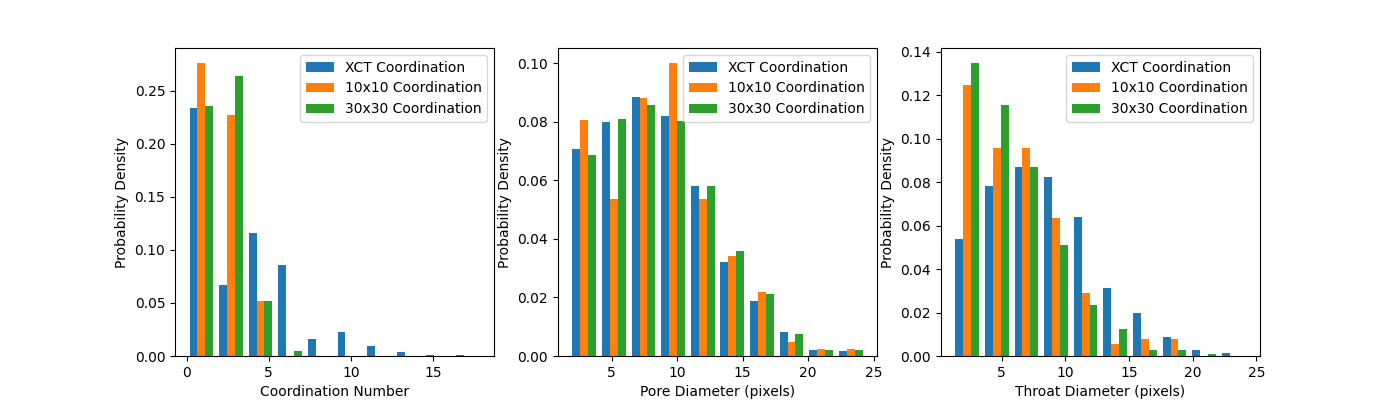

In [6]:
gen_coord1 = op.models.network.coordination_number(network1)
gen_coord2 = op.models.network.coordination_number(network2)

fig, ax = plt.subplots(1, 3, figsize=(14,4))
ret = ax[0].hist([coordination_numbers, gen_coord1, gen_coord2], density = True)
ret = ax[1].hist([pore_diameters, network1['pore.diameter'], network2['pore.diameter']], density = True)
ret = ax[2].hist([pore_diameters, network1['throat.diameter'], network2['throat.diameter']], density = True)

ax[0].set_xlabel('Coordination Number')
ax[0].set_ylabel('Probability Density')
ax[0].legend(['XCT Coordination', '10x10 Coordination', '30x30 Coordination'])
ax[1].set_xlabel('Pore Diameter (pixels)')
ax[1].set_ylabel('Probability Density')
ax[1].legend(['XCT Coordination', '10x10 Coordination', '30x30 Coordination'])
ax[2].set_xlabel('Throat Diameter (pixels)')
ax[2].set_ylabel('Probability Density')
ax[2].legend(['XCT Coordination', '10x10 Coordination', '30x30 Coordination'])

To save as either an SVG or DXF, use the ```export``` module. NOTE: The "design_size" parameter will decide the final unit width and height of the SVG image, but will also change the distance between pores. Use ```design_size = n * 20``` for the best results. In the example below, ```n = 10```, and so, ```design_size = 200```:

In [7]:
design1 = export.network2svg(network1, 10, 10, 200, 200)
design2 = export.network2svg(network2, 30, 30, 600, 600)


save_path1 = os.path.dirname(path) + r'\example_outputs\\network1.svg'
save_path2 = os.path.dirname(path) + r'\example_outputs\\network2.svg'

design1.save_svg(save_path1)
design2.save_svg(save_path2)

In [ ]:
document1 = export.network2dxf(network1)
document2 = export.network2dxf(network2)

document1.saveas('example_outputs/network1.dxf')
document2.saveas('example_outputs/network2.dxf')

To write the SVG file as a rasterized image, we will use ```svglib``` and ```reportlab```:

In [17]:
png_path1 = os.path.dirname(path) + r'\example_outputs\\network1.png'
png_path2 = os.path.dirname(path) + r'\example_outputs\\network2.png'

rldrawing1 = svg2rlg(save_path1)
renderPM.drawToFile(rldrawing1, png_path1, fmt='PNG')

rldrawing2 = svg2rlg(save_path2)
renderPM.drawToFile(rldrawing2, png_path2, fmt='PNG')


In [32]:
plt.close('all')